# Bayesian estimation of Beta variable model

In [45]:
# Import analysis packages
%matplotlib inline
import stan as ps
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
from scipy.stats import beta

# Importing nest_asyncio is only necessary to run pystan in Jupyter Notebooks.
import nest_asyncio
nest_asyncio.apply()

In [46]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

# Bayesian estimation of parameters of a beta random variable (proportion scores example)

The notebook here moves away from any equivalent statistical test that psychology and neuroscience students and reseachers classically apply to analyses proportion scores. Instead we focus on the estimation of parameters of a probability distribution that is more appropriate to describe the data. In this example the data are propoortion scores collected by Mehr, Song & Spelke (2016). This dataset has also been analysed in the similar vain to one sample t-test equivalent in these set of notebooks. So, for a fuller description of the data and methods interested readers are directed to that notebook.

## Why the beta distribution?

Proportions mathematically fall on a scale between $[0,1]$ and as Liu and Zhang (2015) describe the beta desitribution is the natural choice when the dependent (random) variable lies between $[0,1]$ in the suite of general statistical models as it constrains the variable to this interval, whilst being able to take many distributional shapes (see plot below offering great flexibility.

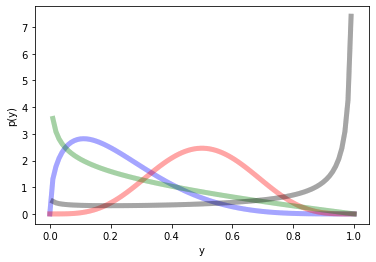

In [59]:
# Set a variety of (alpha & beta) parameter values
a = [1.5, 5, .8, .8]
b =[5, 5, 2, .2]

# Assign seperate colours.
col = ['b-', 'r-', 'g-', 'k-']

# Set linearly spaced xaxis values  between (0,1)
x = np.linspace(beta.ppf(0.0, a, b),
              beta.ppf(1, a, b), 100)

for i in range(0,len(a)):
    plt.plot(x, beta.pdf(x, a[i], b[i]),
       col[i], lw=5, alpha=.1, label='beta pdf');
    #plt.legend()

# Set x and y label.
plt.xlabel('y');
plt.ylabel('p(y)');

The plot above shows the beta distributions flexibility with the range of postive real values the parameters can take.

# Steps of Bayesian data analysis

<font size = "3"> Kruschke (2015) offers a step by step formulation for how to conduct a Bayesian analysis:

1. Identify the relevant data for the question under investigation.

2. Define the descriptive (mathematical) model for the data.

3. Specify the Priors for the model. If scientific research publication is the goal the priors will need to be accepted by a skeptical audience. This should be achievable using prior predictive checks to ascertain if the priors are reasonable.

4. Using Bayes rule estimate the posterior for the parameters of the model using the likelihood and priors. Then use the posterior for conducting your inferences.

5. Conduct model checks. i.e. Posterior predcitive checks.</font> 

<font size = "1">This notebook will follow this approach generally.</font> 

# Step 1 - Identify the relevant data for the question under investigation

In [4]:
# Call github repository were the data is stored
url = "https://raw.githubusercontent.com/ebrlab/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/master/wip/Data/Mehr%20Song%20and%20Spelke%202016%20Experiment%201.csv"

# Import data .csv file into a pandas dataframe
df = pd.read_csv(url)

## Data prep and exploratory analysis

In [5]:
# The data for the specific experiment of interest is in the first 32 rows of the dataframe
red_df = df.iloc[0:32,]

## Plot the data

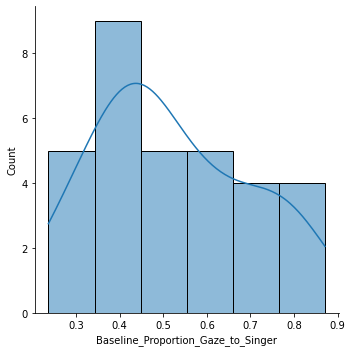

In [6]:
sns.displot(red_df['Baseline_Proportion_Gaze_to_Singer'], kde = True);

# Step 2 - Define the descriptive statistical model \begin{align*}
y_i &\sim Beta(\alpha, \beta) 
\\ \alpha &\sim HalfNormal(0, 10) 
\\ \beta &\sim HalfNormal(0, 10) 
\end{align*} 

<font size = "3">The formulation for presenting statistical models here follows that used by McElreath (2020) for its intuitive nature. In plain english the model specifies that the dependent variable $y_i$ is distributed as a beta distribution in terms of the likelihood. The $\alpha$ and $\beta$ parameters are to be estimated. With the priors for both the $\alpha$ and $\beta$ parameter being $HalfNormal(0, 10)$ 

# Step 3 - Specify prior values 

The priors choosen above to be weakly informative as suggested by the Stan team at https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations, in addition for such a simple model the effects are minimal and as non-expert in gaze proportion scores these priors bake in this ignorance whilst retaining some regularisation to the inference. This is a standard justification in the Bayesian literature Sarma & Kay (2020) (this is not saying defaults are always appropriate). If readers have criticisms and suggestions, good! Please let the authors know.

## Stan model

In [116]:
# Stan beta distribution model for analysing a set of proportion scores

beta_m = '''

data{

int<lower = 1> N; // Number of data points
vector[N] y; // Dependent variable

// Prior values
real a_mu;
real b_mu;
real a_sigma;
real b_sigma;

// Prior or posterior predictive checks setting variable 
int<lower = 0, upper =1> onlyprior;

}

parameters{

// Model paramaters to be estimated
real<lower=0> a;// Bounded at 0 
real<lower=0> b; // Bounded at 0
 
}

model{
//priors
a ~ normal(a_mu, a_sigma);
b ~ normal(b_mu, b_sigma);

if(!onlyprior){ // Run likelihood and estimate model parameters
// Likliehood
y ~ beta(a, b);
    }
}
generated quantities{
vector[N] yrep;
for(i in 1:N){
yrep[i] = beta_rng(a,b);
}

// Calculate expected value of beta random variable
real EV = a/(a+b);

// Differnce the expected value and perfect non-biased gaze proportion of .5
real diff = EV - .5;
}
'''

In [126]:
# Generate python dictionary to pass to Stan model to sample and run Bayesian One sample.
data = {'N': len(red_df),
        'y': red_df["Baseline_Proportion_Gaze_to_Singer"].values,
        'a_mu': 0.,
        'b_mu': 0.,
        'a_sigma': 10.,
        'b_sigma': 10.,
        # Set to zero to run with likelihood and fit the model to the data.
        'onlyprior': 0}

In [127]:
# The build function can be called and passed the model string specified above to compile into C++ code.
# Ignore warnings the priors are set in data block.
sm  = ps.build(beta_m, data = data)

Building...



Building: found in cache, done.Messages from stanc:


In [142]:
#Using capture here to hide output as model here is simple and has no issues amd it keeps screen clear
# Fit model to the data and sample the posteriors
fit = sm.sample(num_chains = 4, num_samples = 1000)

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: beta_lpdf: Second shape parameter is inf, but must be positive finite! (in '/tmp/httpstan_jnfxfbq8/model_4d2runpg.stan', line 35, column 0 to column 15)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 1.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.17 se

In [143]:
# Output the key parameters and generated quantities
az.summary(fit,var_names = ['a', 'b', 'EV', 'diff'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,4.124,0.985,2.387,5.995,0.032,0.023,941.0,1105.0,1.0
b,3.736,0.881,2.003,5.290,0.029,0.021,947.0,1029.0,1.0
EV,0.524,0.030,0.468,0.579,0.000,0.000,3630.0,2293.0,1.0
diff,0.024,0.030,-0.032,0.079,0.000,0.000,3630.0,2293.0,1.0


In [144]:
# Put all MCMC samples into Pandas dataframe
fit_df = fit.to_frame()

#  Step 5 - Posterior checks

## Plot posteriors

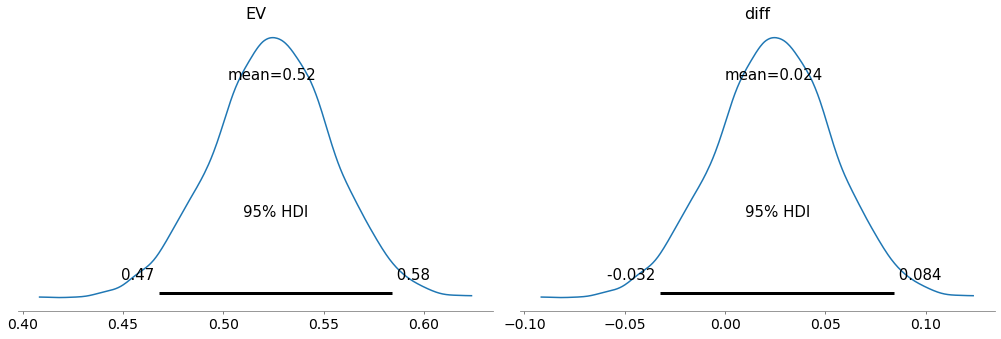

In [145]:
az.plot_posterior(fit,var_names = ('EV', 'diff'), hdi_prob = .95);

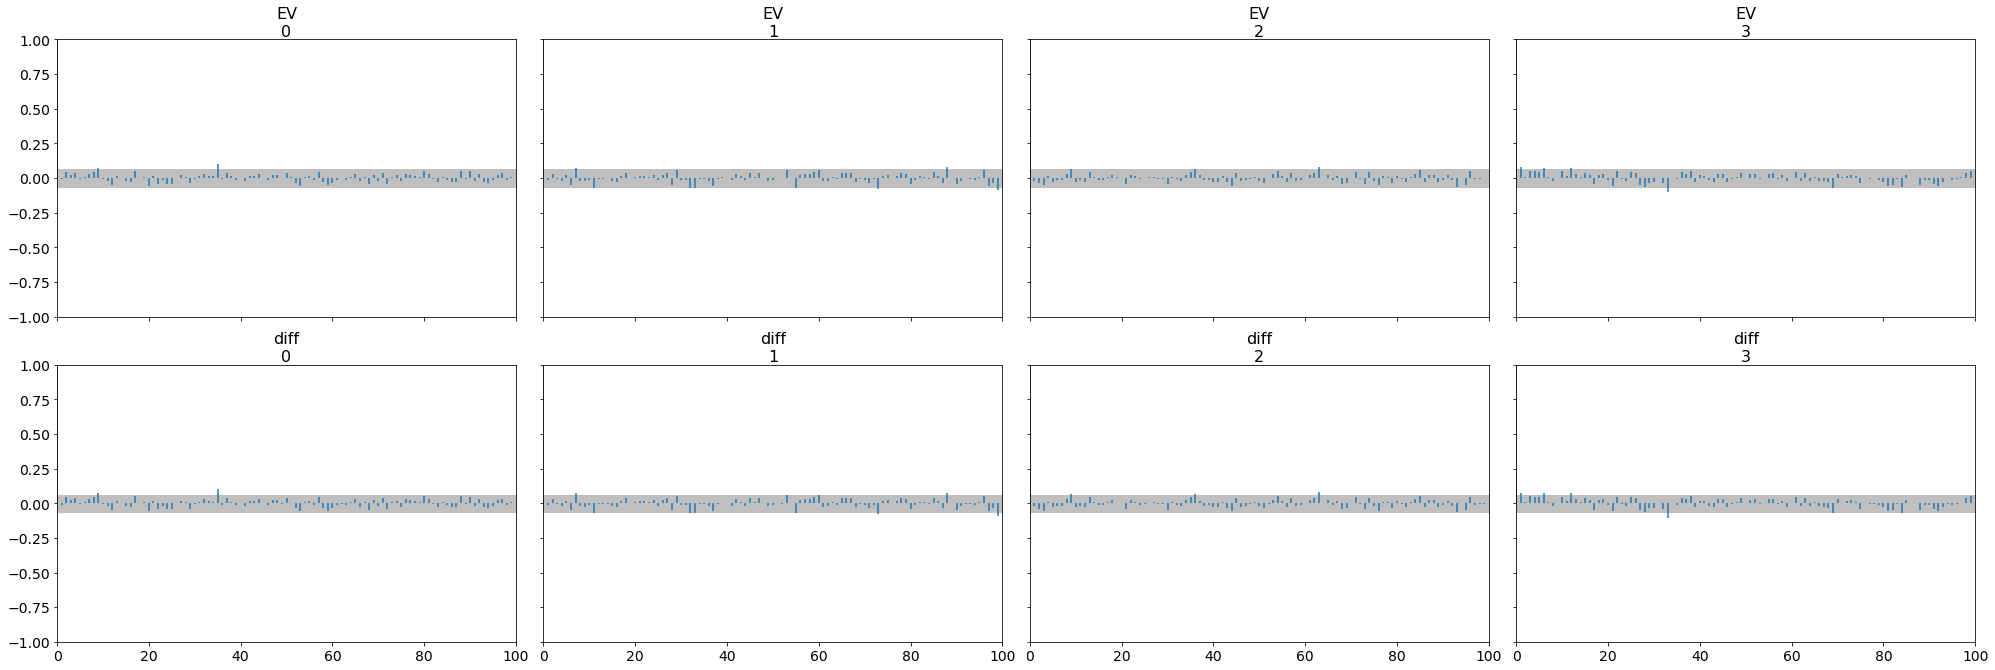

In [146]:
# Plot autocorreltion plots for MCMC chains.
az.plot_autocorr(fit, var_names = ('EV', 'diff'));

Autocorrelation plots show no issues. Autocorrelation values quickly returning to 0.

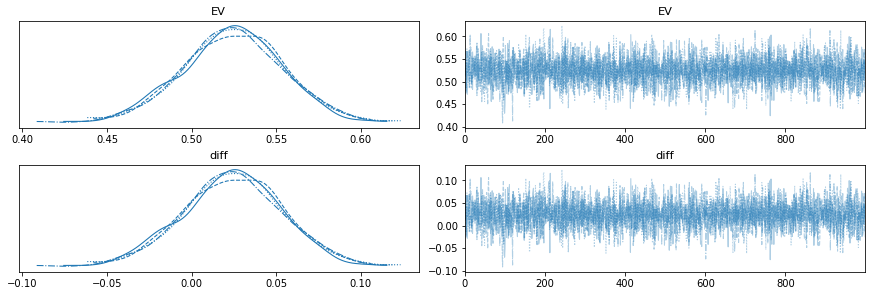

In [147]:
# Plot traceplots for the MCMC chains.
az.plot_trace(fit, var_names = ('EV', 'diff'));

Traceplots show no pathologies and with r-hat values at 1 suggest they have converged with the appearance of ''Fuzzy Caterpillars''

## Posterior predictive checks

In [134]:
# Generate inference object from Stan model and posterior samples.
idata = az.from_pystan(posterior = fit, posterior_model = sm, posterior_predictive=['yrep'], observed_data = 'y')   

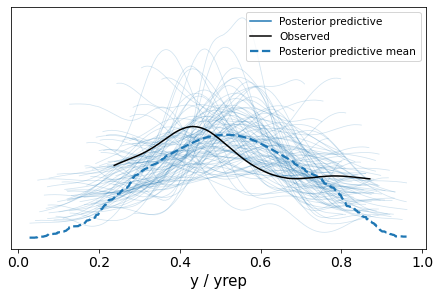

In [135]:
# Plot posterior simulated data sets for posterior predictive check
if data['onlyprior'] == 0:
    az.plot_ppc(idata, data_pairs = {"y" : "yrep"}, num_pp_samples = 100, observed = True);
else:
    az.plot_ppc(idata, data_pairs = {"y" : "yrep"}, num_pp_samples = 100, observed = False);

The posterior predicitve checks show that this model is better than the normal likelihood model demonstrated in the one-sample t-test notebook, in the sense that this model does not (because it cannot) predict impossible values. However, the overall model fit is relatively poor to the observed data. This is likely a result of the small sample size to estimate the parameters with high certainty with the flexibilty of the beta distribution.

# Reporting the results of the Bayesian beta estimation

<font size = "3">As Kruschke (2015) correctly points out there is no standard formula or presentation method for results like the APA guide for reporting frequentist analyses using the Bayesian framework. It is likely there never will be, because as McElreath (2020) explains; Bayesian data analysis is more like a engineering approach to the problem and the resulting model that is fit will be analysis specific. In addition, as Gabry et al, (2019) have argued visualisations maybe even more key, so all the visualisations above would have to be included with any write up.
   
Anyway, the write up below generally follows the advice of Kruschke (2015) chapter 25. In any application though it comes down to the problem to be described and the audience that needs to be convinced. </p><br/>

<h2>Write up</h2><br/>
A simple Bayesian beta distribution model was fit to the baseline gaze proportion scores. This was completed using the Stan probabilistic programming language Carpenter et al. (2017). The priors that were used were weakly informative half normal with $\mu$ of 0 and $\sigma$ of 10 for both the $\alpha$ and $\beta$ parameters of the beta distribution.

Four MCMC chains were ran each taking 2000 samples each. For each of the chains the first 1000 samples were used as warmup samples. This left 2000 samples for estimating the posteriors and therefore for conducting any inferences or posterior predicitve checks. In terms of the $\alpha$ and $\beta$ parameters the expected values (means) and the credible intervals (95%) that were estimated were, $\mathbf{E}(\alpha$) = 4.18, CI = [2.495, 5.825] and $\mathbf{E}(\beta$) = 3.79, CI = [2.430, 5.522]. However, the key statistic to calculate for this study was the expected value of the baseline proportion scores modelled as a beta random variable. The expected value was calculated using the relevant formula $\mu =\frac{\alpha}{\alpha + \beta}$ (see, Taboga, 2017). The calculated expected value of beta variable from the posterior samples was $\mathbf{E}(\mu)$ = .52, CI = [0.470, 0.580]; with the its difference between the expected value distribution from zero bias (e.g, baseline gaze proportion score of .5) = 0.02, CI = [-0.030,0.080]. The difference scores were very close but did not cross 0 within the standardly applied 95% probability interval under the model and its assumptions.

# Population parameters and nuisance variables.

It is important to point out the model here and the classcial one sample t-test model used by Mehr et al. (2016) are attempts to estiamte a population average. Where as Mehr (2016) were attempting to establish if there was any buias in their data to effect their later analyses. Unfortuntely a statistical model like the t-test or the model applied abovee cannot tell you if their bias in the data in terms of that data being a nuisance varaible. By simple looking at the observed data very few infants showed no bias (.5) in their scores with many with some  deviation from .5. It would have been more appropriate for this factor to be included as a covariate in some form of regression model. The take home message for readers is that the example model above can estimate a population parameter but it is not apppropriate to use statistical models of population parameters for determining nuisance variables. For futher discussion see Sassenhagen and Alday (2016).

# References

Carpenter, B., Gelman, A., Hoffman, M. D., Lee, D., Goodrich, B., Betancourt, M., ... & Riddell, A. (2017). Stan: a probabilistic programming language. Grantee Submission, 76(1), 1-32.

Dienes, Z. (2014). Using Bayes to get the most out of non-significant results. Frontiers in psychology, 5, 781.

Gabry, J., Simpson, D., Vehtari, A., Betancourt, M., & Gelman, A. (2019). Visualization in Bayesian workflow. Journal of the Royal Statistical Society: Series A (Statistics in Society), 182(2), 389-402.
    
Kruschke, J. (2015). Doing Bayesian data analysis: A tutorial with R, JAGS and Stan. Oxford, England: Academic Press.    

Liu, F., & Kong, Y. (2015). zoib: An R Package for Bayesian Inference for Beta Regression and Zero/One Inflated Beta Regression. R J., 7(2), 34.
    
McElreath, R. (2020). Statistical rethinking: A Bayesian course with examples in R and Stan.Boca Raton: CRC Press.

Mehr, S. A., Song. L. A., & Spelke, E. S. (2016). For 5-month-old infants, melodies are social. Psychological Science, 27, 486-501.

Sarma, A., & Kay, M. (2020, April). Prior Setting In Practice: Strategies and rationales used in choosing prior distributions for Bayesian analysis. In Proceedings of the 2020 CHI Conference on Human Factors in Computing Systems (pp. 1-12).

Sassenhagen, J., & Alday, P. M. (2016). A common misapplication of statistical inference: Nuisance control with null-hypothesis significance tests. Brain and language, 162, 42-45.

Taboga, Marco (2017). "Beta distribution", Lectures on probability theory and mathematical statistics, Third edition. Kindle Direct Publishing. Online appendix. https://www.statlect.com/probability-distributions/beta-distribution.

# Exercises for motivated readers
1. Check how narrow the HDI interval % must be for the estimated difference posterior before it doesnt cross 0.
2. Write a short description for how this change is both arbitary and might cause discussion for researchers in terms of interpreting results.